In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re # Import regular expression library for text cleaning
import nltk # Import NLTK (Natural Language Toolkit) for text preprocessing

In [2]:
#Access Google Drive files inside a Google Colab notebook.
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [3]:
# File paths (update if your folder name is different)
fake_path = '/content/drive/MyDrive/FAKE NEWS DETECTION\/Fake.csv'
true_path = '//content/drive/MyDrive/FAKE NEWS DETECTION\/True.csv'

# Load datasets
fake_df = pd.read_csv(fake_path)
true_df = pd.read_csv(true_path)

# Add label column: 0 = fake, 1 = real
fake_df['label'] = 0
true_df['label'] = 1

# Combine both datasets
df = pd.concat([fake_df, true_df], axis=0)
df = df.sample(frac=1).reset_index(drop=True)  # Shuffle


In [4]:
#check for null values
df.isnull().sum()

,0
title,0
text,0
subject,0
date,0
label,0


In [5]:
#show dataset
print(df.shape)
print(df.columns)
df.head()

(44898, 5)
Index(['title', 'text', 'subject', 'date', 'label'], dtype='object')


,title,text,subject,date,label
0,PM May is driving Britain to cliff-edge Brexit...,"BRIGHTON, England (Reuters) - A cliff-edge Bre...",worldnews,"September 27, 2017",1
1,Top Intelligence Committee Member: ‘No Eviden...,FBI Director James Comey met with the House In...,News,"March 11, 2017",0
2,Kremlin-backed broadcaster launches French lan...,PARIS (Reuters) - The Kremlin-funded Russian b...,worldnews,"December 18, 2017",1
3,OUCH! Things Take Ugly Turn For MATT LAUER Whe...,"Matt Lauer, of the failing Today Show had an e...",left-news,"Mar 9, 2017",0
4,WATCH: Kellyanne Conway Wore Out Her Welcome ...,CNN host Anderson Cooper s reactions to Kellya...,News,"May 10, 2017",0


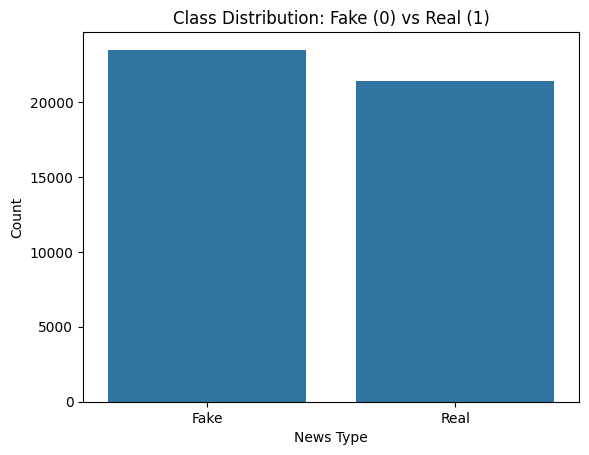

In [6]:
# Create a bar chart to visualize the number of Fake vs Real news samples
sns.countplot(x='label', data=df)

# Add a title and axis labels for better readabilit
plt.title("Class Distribution: Fake (0) vs Real (1)")
plt.xlabel("News Type")
plt.ylabel("Count")

# Replace numeric x-axis tick labels with class names
plt.xticks([0, 1], ['Fake', 'Real'])

# Display the plot
plt.show()


The dataset in this visualization is balanced between fake and real news, making it ideal for training classification models.

In [7]:
from nltk.corpus import stopwords # Import stopwords list (e.g., 'the', 'is', 'and') to remove common non-informative words
from nltk.stem import PorterStemmer # Import PorterStemmer for reducing words to their base form
nltk.download('stopwords')# Download stopwords data from NLTK (only needs to be done once)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:

# Keep only the 'text' and 'label' columns for analysis
df = df[['text', 'label']]

# Remove rows with missing values (if any)
df.dropna(inplace=True)  # In case any nulls


/tmp/ipython-input-8-4248167381.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)  # In case any nulls


In [9]:
# Define stopwords and stemmer for preprocessing
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Function to clean and preprocess text
def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>+', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # Keep only letters
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces

    # Tokenize and remove stopwords, then apply stemming
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    return ' '.join(words) # Return cleaned and processed text


In [10]:
#calling function for text cleaning
df['clean_text'] = df['text'].apply(clean_text)
df[['text', 'clean_text']].head()

,text,clean_text
0,"BRIGHTON, England (Reuters) - A cliff-edge Bre...",brighton england reuter cliff edg brexit risk ...
1,FBI Director James Comey met with the House In...,fbi director jame comey met hous intellig comm...
2,PARIS (Reuters) - The Kremlin-funded Russian b...,pari reuter kremlin fund russian broadcast rt ...
3,"Matt Lauer, of the failing Today Show had an e...",matt lauer fail today show exclus interview pr...
4,CNN host Anderson Cooper s reactions to Kellya...,cnn host anderson cooper reaction kellyann con...


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer           # Convert cleaned text into numerical features using TF-IDF
from sklearn.model_selection import train_test_split                  # Split the dataset into training and testing sets
from sklearn.linear_model import LogisticRegression                   # Logistic Regression classifier for binary classification
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix   # Evaluation metrics to assess model performance


In [12]:
# Convert text data into TF-IDF features (keep only top 5000 words)
tfidf = TfidfVectorizer(max_features=5000)  # You can change this number

# Fit and transform the cleaned text column into numerical feature vectors
X = tfidf.fit_transform(df['clean_text']).toarray()

# Extract target labels (0 for fake, 1 for real)
y = df['label']


In [13]:
# Split the data into training (80%) and testing (20%) sets
# random_state ensures reproducibility (same split every time you run)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Initialize the Logistic Regression model with a higher iteration limit
model = LogisticRegression(max_iter=200)

# Train the model on the training data
model.fit(X_train, y_train)


LogisticRegression(max_iter=200)

In [15]:
# Use the trained model to predict labels on the test set
y_pred = model.predict(X_test)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.987750556792873

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      4732
           1       0.99      0.99      0.99      4248

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980


Confusion Matrix:
 [[4678   54]
 [  56 4192]]


In [16]:
# Sample news input
input_text = "The government announced a new policy today regarding fuel prices in the national budget."

# Preprocess
cleaned_input = clean_text(input_text)

# Vectorize
vector_input = tfidf.transform([cleaned_input])

# Predict
prediction = model.predict(vector_input)

# Result
print("🔍 Prediction:", "REAL News ✅" if prediction[0] == 1 else "FAKE News ❌")


🔍 Prediction: FAKE News ❌


In [17]:
import pickle

# Save trained model
pickle.dump(model, open("fake_news_model.pkl", "wb"))

# Save TF-IDF vectorizer
pickle.dump(tfidf, open("tfidf_vectorizer.pkl", "wb"))


In [18]:
from google.colab import files
files.download("fake_news_model.pkl")   #download model
files.download("tfidf_vectorizer.pkl")  #download


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>